# Image date estimation with convolutional neural networks
## Pekko Ojanen
### 18.05.2017

In this project, historical images are first scraped from the internet and then convolutional neural networks (CNNs) are built to estimate from what year a previously unseen image originally is. Two different models are evaluated: CNN trained from scratch and a fine-tuned [VGG16 net from Oxford Visual Geometry Group](https://arxiv.org/abs/1409.1556). Despite smallish dataset size, both models achieve good performance.

## Data acquisition and preprocessing
First, all the needed libraries are imported.

In [2]:
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from glob import glob
from scipy.misc import imresize
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Convolution2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

DIR = os.getcwd()
%matplotlib inline

Define a small helper function for checking if a string contains only integers.

In [3]:
def is_number(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

All historical images are scraped from [shorpy.com](https://shorpy.com) and saved into a local folder. Image dates are acquired from HTML title elements and used as a part of the image filenames when saving to the folder.

In [4]:
if 1 == 0:
    for i in xrange(1786): 
        page = requests.get('http://www.shorpy.com/node?page={}'.format(i))
        soup = BeautifulSoup(page.content, 'html5lib')
        divs = soup.find_all('div', class_='node')
    
        for div in divs:
            year = div.h2.a.get_text().split()[-1]
        
            if (is_number(year) == False):
                continue
        
            img_url = div.find(class_='content').select('a')[1].img['src']
            img_data = requests.get(img_url).content

            with open('Imgs\\' + year + '_' + str(i) + '.jpg', 'wb') as handler:
                handler.write(img_data)

Move into the filled image folder.

In [5]:
%cd Imgs/

C:\Users\Pekko\Documents\Programming\Photo_aging\Imgs


If an image's filename does not contain a year in a reasonable range, remove it.

In [6]:
fnames = glob('*.jpg')

if 1 == 0:
    for fname in fnames:
        if int(fname.split('_')[0]) not in range(1839, 2017):
            os.remove(fname)

Read all the images and their corresponding years into numpy arrays.

In [7]:
X = np.array([cv2.imread(DIR + '\\Imgs\\' + fname) for fname in fnames])
y = np.array([int(fname.split('_')[0]) for fname in fnames])

Remove potential images of type None, which were not successfully read by OpenCV.

In [8]:
none_idx = [i for i, x in enumerate(X) if x is None]
print 'Nones:', len(none_idx)

X = np.delete(X, none_idx)
y = np.delete(y, none_idx)

Nones: 6


Let's explore the distribution of image years. As can be seen from the histogram below, the distribution is quite uneven and most images are between the years of 1899 and 1965.

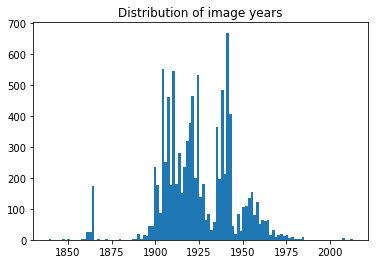

In [9]:
plt.hist(y, bins=len(np.unique(y)))
plt.title('Distribution of image years');

The uneven distribution is not that great for training a deep learning model. Let's remove some of the rarer years to ensure a decent amount of examples from each year.

In [10]:
outliers = np.where((y >= 1965) | (y <= 1899))[0]
X = np.delete(X, outliers, axis=0)
y = np.delete(y, outliers)

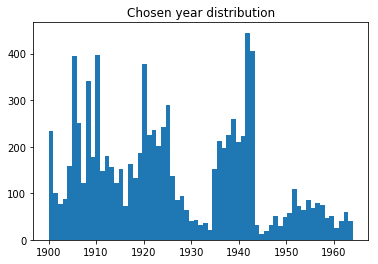

In [11]:
plt.hist(y, bins=len(np.unique(y)))
plt.title('Chosen year distribution');

The new distribution is still quite unbalanced but still, better than the previous.

In [12]:
print X.shape[0]

9210


We are left with 9210 images. The images are of different sizes and they must be resized to certain width and height so they can be feeded into a convolutional neural network. 224 x 224 pixels is chosen as it is also the input size of the original VGG16 model.

In [13]:
X = np.array([imresize(img, size=(224, 224, 3)) for img in X])

Let's see a couple of examples from our collection. The bear image is cool. The dataset includes both colour and black and white images.

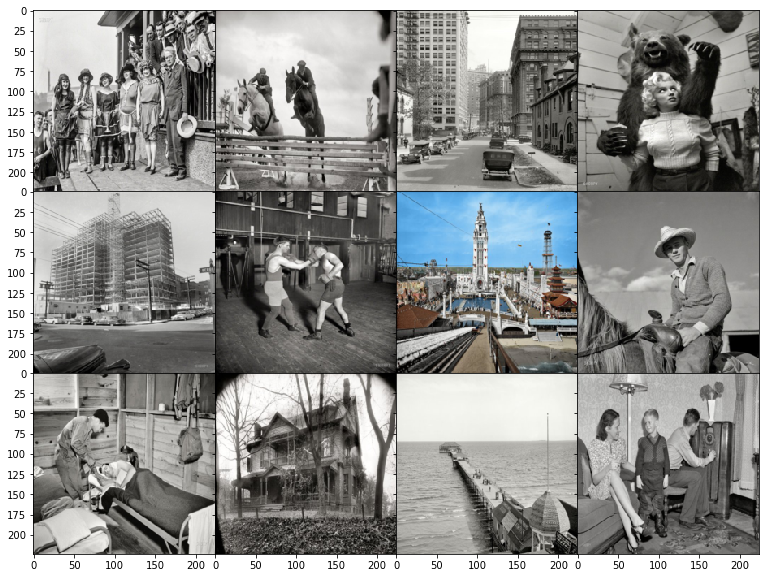

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(13,10), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)

for ax in axs:
    for i in xrange(len(ax)):
        ax[i].imshow(cv2.cvtColor(X[np.random.randint(0, len(X))], cv2.COLOR_BGR2RGB))

Reshape the image matrix to a shape suitable for Theano.

In [14]:
X = np.reshape(X, (X.shape[0], 3, 224, 224))

Normalize the image matrix by substracting the mean and dividing by the standard deviation.

In [15]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Split the images and years into 70 % training, 15 % validation and 15 % testing sets.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
val_size = len(X_test) // 2
X_val, y_val = X_test[:val_size], y_test[:val_size]
X_test, y_test = X_test[val_size:], y_test[val_size:]

In [17]:
print 'Training set size:', len(X_train)
print 'Validation set size:', len(X_val)
print 'Test set size:', len(X_test)

Training set size: 6447
Validation set size: 1381
Test set size: 1382


Delete X and y matrices to save some precious memory.

In [18]:
del X, y

## Convolutional neural network from scratch

Define a function which returns a simple convolutional neural network. Adam takes care of the optimization and mean absolute error (MAE) is used as the error metric. MAE is selected because it is intuitive and easily interpretable versus human results in this context.

In [18]:
def get_cnn_scratch():
    model = Sequential([
        Convolution2D(64, 3, 3, activation='relu', input_shape=(3, 224, 224)),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(64, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mae')
    return model

Define mean absolute error.

In [46]:
def mae(x):
    return np.mean(np.abs(x - y_test))

Define a small helper function to train the models with less typing.

In [54]:
def fit(model, nb_epoch):
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              nb_epoch=nb_epoch, batch_size=64)

Initialize the CNN model and start training it in batches of 64 images. Learning rate is initially set a bit higher to speed up the process. 

In [23]:
cnn = get_cnn_scratch()

In [19]:
cnn.optimizer.lr = 0.01
fit(cnn, 3)

Train on 6447 samples, validate on 1381 samples
Epoch 1/3
6447/6447 [==============================] - 99s - loss: 1774.8484 - val_loss: 1416.2167
Epoch 2/3
6447/6447 [==============================] - 42s - loss: 654.5258 - val_loss: 442.1104
Epoch 3/3
6447/6447 [==============================] - 41s - loss: 15.7644 - val_loss: 22.5969


In three epochs, the model overfits and starts to give somewhat reasonable results. Reduce the learning rate and continue.

In [20]:
cnn.optimizer.lr = 0.001
fit(cnn, 8)

Train on 6447 samples, validate on 1381 samples
Epoch 1/8
6447/6447 [==============================] - 41s - loss: 13.5128 - val_loss: 15.0627
Epoch 2/8
6447/6447 [==============================] - 41s - loss: 13.0515 - val_loss: 13.6019
Epoch 3/8
6447/6447 [==============================] - 41s - loss: 12.8111 - val_loss: 13.4122
Epoch 4/8
6447/6447 [==============================] - 41s - loss: 12.7748 - val_loss: 13.2333
Epoch 5/8
6447/6447 [==============================] - 41s - loss: 12.3181 - val_loss: 12.7226
Epoch 6/8
6447/6447 [==============================] - 41s - loss: 12.2793 - val_loss: 12.8183
Epoch 7/8
6447/6447 [==============================] - 41s - loss: 12.2160 - val_loss: 13.0580
Epoch 8/8
6447/6447 [==============================] - 41s - loss: 12.0298 - val_loss: 12.7451


Reduce the learning rate further. Results are starting to look pretty decent on the validation set. The model is still overfitting but since the validation loss is decreasing, that is fine.

In [21]:
cnn.optimizer.lr = 0.0001
fit(cnn, 6)

Train on 6447 samples, validate on 1381 samples
Epoch 1/6
6447/6447 [==============================] - 41s - loss: 12.0343 - val_loss: 14.1900
Epoch 2/6
6447/6447 [==============================] - 41s - loss: 11.6135 - val_loss: 12.8969
Epoch 3/6
6447/6447 [==============================] - 41s - loss: 11.6137 - val_loss: 12.9472
Epoch 4/6
6447/6447 [==============================] - 41s - loss: 11.1235 - val_loss: 12.1453
Epoch 5/6
6447/6447 [==============================] - 41s - loss: 10.4095 - val_loss: 12.5776
Epoch 6/6
6447/6447 [==============================] - 41s - loss: 10.4417 - val_loss: 13.4446


Starting to look good! The best validation loss so far is 12.1453. After that we seem to start overfitting quite badly but let's try for two more epochs.

In [22]:
fit(cnn, 2)

Train on 6447 samples, validate on 1381 samples
Epoch 1/2
6447/6447 [==============================] - 42s - loss: 9.9562 - val_loss: 12.7605
Epoch 2/2
6447/6447 [==============================] - 41s - loss: 9.7180 - val_loss: 12.5865


This will do. Save current weights of the network with the validation set MAE at 12.5865.

In [37]:
cnn.save_weights('../Models/val_mae_12-5865.hdf5')

In [24]:
cnn.load_weights('../Models/val_mae_12-5865.hdf5')

Predict the years for the test set and check the results.

In [28]:
preds = cnn.predict(X_test, batch_size=64).ravel()

In [29]:
print 'MAE on the test set:', mae(preds)
print 'MAE (rounded):', mae(np.round(preds))

MAE on the test set: 11.4574881745
MAE (rounded): 11.4565846599


MAE is even lower on the test set than on the validation set. By rounding the year predictions to integers we get a very slight improvement. Next, we'll plot the error distribution.

In [31]:
errors = np.abs(np.round(preds) - y_test)

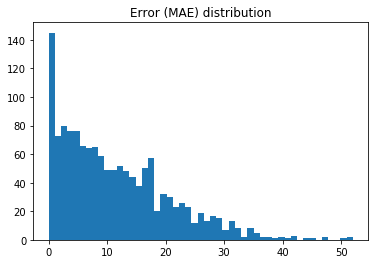

In [33]:
plt.hist(errors, bins=len(np.unique(errors)))
plt.title('Error (MAE) distribution');

Lots of images have a prediction of zero. Let's examine what kind of images had the biggest prediction error (over 40 years).

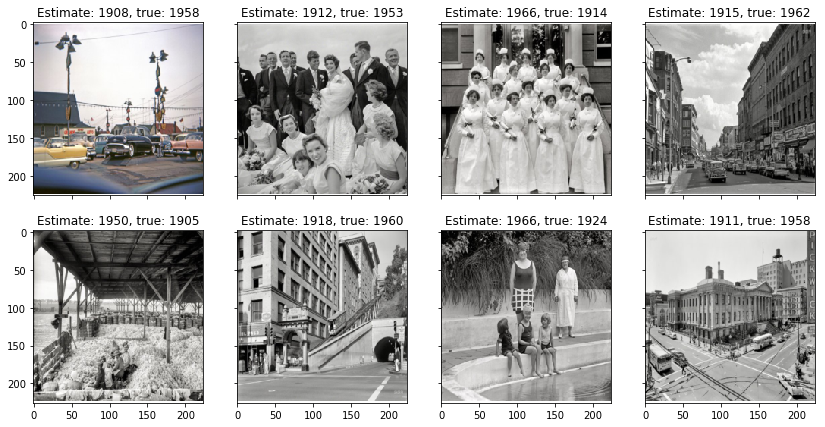

In [34]:
worst = np.where(errors > 40)[0]
fig, axs = plt.subplots(2, 4, figsize=(14,7), sharex='col', sharey='row')

i = 0
for ax in axs:
    for col in xrange(len(ax)):
        img = X_test[worst[i]] * X_std + X_mean
        img = np.reshape(img, (224, 224, 3)).astype(np.uint8)
        
        ax[col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[col].set_title('Estimate: {:.0f}, true: {}'.format(preds[worst[i]], 
                                                            y_test[worst[i]]))
        i += 1

Others seem quite difficult but the coloured one with cars perhaps should have been timed more accurately. Well, there is colour and there are clearly more modern cars than the ones available at the beginning of the 20th century.

The model timed a lot of images perfectly correct though. Let's see some of those.

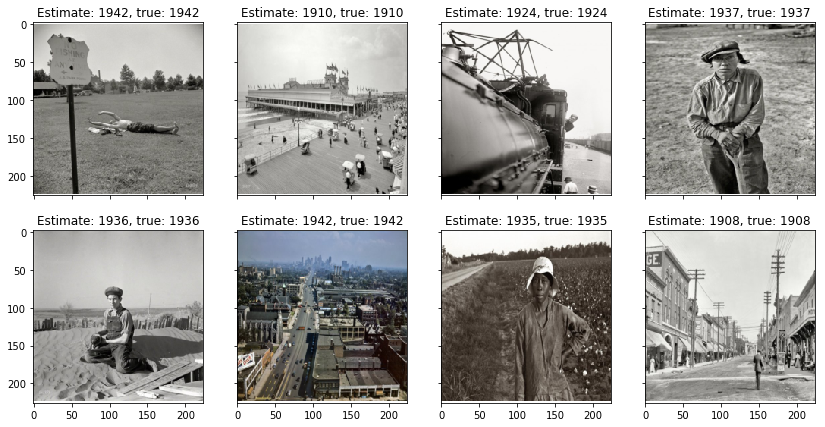

In [35]:
no_errors = np.where(errors == 0)[0][:8]
fig, axs = plt.subplots(2, 4, figsize=(14,7), sharex='col', sharey='row')

i = 0
for ax in axs:
    for col in xrange(len(ax)):
        img = X_test[no_errors[i]] * X_std + X_mean
        img = np.reshape(img, (224, 224, 3)).astype(np.uint8)
        
        ax[col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[col].set_title('Estimate: {:.0f}, true: {}'.format(preds[no_errors[i]],
                                                            y_test[no_errors[i]]))
        i += 1

## Using pre-trained convolutional filters of VGG16
Next, we will utilize pre-trained convolutional filters from VGG16 and finetune a couple of fully connected layers on top of that.

Define a function which returns fully connected layers to add to VGG16.

In [39]:
def get_dense_layers():
    return [
        Flatten(input_shape=(512, 7, 7)),
        Dropout(0.4),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ]

Define VGG16 model without the fully connected layers. Set all convolutional layers as untrainable.

In [40]:
def get_vgg_cnn():
    vgg16 = VGG16(include_top=False, input_shape=(3, 224, 224))
    
    for layer in vgg16.layers:
        layer.trainable = False
    
    conv_model = Sequential(vgg16.layers)
    dense = Sequential(get_dense_layers())
    conv_model.add(dense)
    
    conv_model.compile(optimizer='adam', loss='mae')
    return conv_model

Initialize the VGG model and start to train. Again, initial learning rate is set a bit higher.

In [41]:
vgg_cnn = get_vgg_cnn()

In [46]:
vgg_cnn.optimizer.lr = 0.01
fit(vgg_cnn, 3)

Train on 6447 samples, validate on 1381 samples
Epoch 1/3
6447/6447 [==============================] - 67s - loss: 1774.9017 - val_loss: 1590.7784
Epoch 2/3
6447/6447 [==============================] - 66s - loss: 657.3406 - val_loss: 724.5588
Epoch 3/3
6447/6447 [==============================] - 65s - loss: 18.3149 - val_loss: 18.1388


Decrease the learning rate and continue.

In [47]:
vgg_cnn.optimizer.lr = 0.001
fit(vgg_cnn, 8)

Train on 6447 samples, validate on 1381 samples
Epoch 1/8
6447/6447 [==============================] - 66s - loss: 12.7866 - val_loss: 13.5785
Epoch 2/8
6447/6447 [==============================] - 66s - loss: 12.5400 - val_loss: 12.2301
Epoch 3/8
6447/6447 [==============================] - 66s - loss: 12.3195 - val_loss: 11.9980
Epoch 4/8
6447/6447 [==============================] - 66s - loss: 11.9244 - val_loss: 25.5856
Epoch 5/8
6447/6447 [==============================] - 66s - loss: 11.5720 - val_loss: 12.3210
Epoch 6/8
6447/6447 [==============================] - 66s - loss: 11.3354 - val_loss: 11.9133
Epoch 7/8
6447/6447 [==============================] - 66s - loss: 11.0903 - val_loss: 11.6336
Epoch 8/8
6447/6447 [==============================] - 65s - loss: 11.1177 - val_loss: 11.6761


Starting to look quite good, the validation MAE is already lower than with the CNN built from scratch.

In [48]:
vgg_cnn.save_weights('../Models/vgg_11-6761.hdf5')

In [87]:
vgg_cnn.load_weights('../Models/vgg_11-6761.hdf5')

Set a low learning rate and see if there is still room for improvement.

In [90]:
vgg_cnn.optimizer.lr = 0.00001
fit(vgg_cnn, 3)

Train on 6447 samples, validate on 1381 samples
Epoch 1/3
6447/6447 [==============================] - 67s - loss: 11.6734 - val_loss: 13.1096
Epoch 2/3
6447/6447 [==============================] - 66s - loss: 11.0933 - val_loss: 12.1438
Epoch 3/3
6447/6447 [==============================] - 66s - loss: 11.0073 - val_loss: 11.9340


In [91]:
fit(vgg_cnn, 3)

Train on 6447 samples, validate on 1381 samples
Epoch 1/3
6447/6447 [==============================] - 66s - loss: 10.9586 - val_loss: 12.2154
Epoch 2/3
6447/6447 [==============================] - 66s - loss: 10.7908 - val_loss: 12.7531
Epoch 3/3
6447/6447 [==============================] - 66s - loss: 10.5310 - val_loss: 11.6579


In [92]:
vgg_cnn.save_weights('../Models/vgg_11-6579.hdf5')

In [93]:
vgg_cnn.load_weights('../Models/vgg_11-6579.hdf5')

In [94]:
fit(vgg_cnn, 3)

Train on 6447 samples, validate on 1381 samples
Epoch 1/3
6447/6447 [==============================] - 67s - loss: 10.1831 - val_loss: 11.9916
Epoch 2/3
6447/6447 [==============================] - 66s - loss: 9.9040 - val_loss: 13.0195
Epoch 3/3
6447/6447 [==============================] - 66s - loss: 9.8041 - val_loss: 12.1479


In [95]:
fit(vgg_cnn, 3)

Train on 6447 samples, validate on 1381 samples
Epoch 1/3
6447/6447 [==============================] - 67s - loss: 9.7515 - val_loss: 11.9177
Epoch 2/3
6447/6447 [==============================] - 66s - loss: 9.6676 - val_loss: 11.5025
Epoch 3/3
6447/6447 [==============================] - 66s - loss: 10.4879 - val_loss: 11.4643


In [96]:
vgg_cnn.save_weights('../Models/vgg_11-4643.hdf5')

In [97]:
vgg_cnn.load_weights('../Models/vgg_11-4643.hdf5')

In [98]:
fit(vgg_cnn, 3)

Train on 6447 samples, validate on 1381 samples
Epoch 1/3
6447/6447 [==============================] - 67s - loss: 9.5703 - val_loss: 11.7942
Epoch 2/3
6447/6447 [==============================] - 66s - loss: 9.4066 - val_loss: 11.6923
Epoch 3/3
6447/6447 [==============================] - 66s - loss: 9.1381 - val_loss: 11.8556


In [42]:
vgg_cnn.load_weights('../Models/vgg_11-4643.hdf5')

Validation MAE of 11.4643 is what we are able to squeeze out from this. Next, predictions on the test set are made.

In [43]:
vgg_preds = vgg_cnn.predict(X_test, batch_size=64).ravel()

In [47]:
print 'MAE on the test set:', mae(vgg_preds)
print 'MAE (rounded):', mae(np.round(vgg_preds))

MAE on the test set: 10.7410492076
MAE (rounded): 10.7366136035


Below 11 years, nice! Rounding the predictions helps slightly again.

In [48]:
vgg_errors = np.abs(np.round(vgg_preds) - y_test)

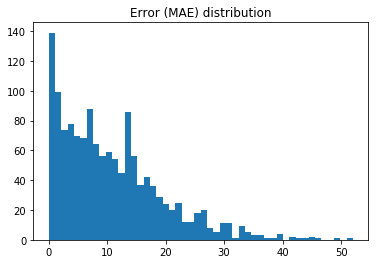

In [49]:
plt.hist(vgg_errors, bins=len(np.unique(vgg_errors)))
plt.title('Error (MAE) distribution');

Finally, let's examine whether the worst predictions are similar than with the CNN trained from scratch.

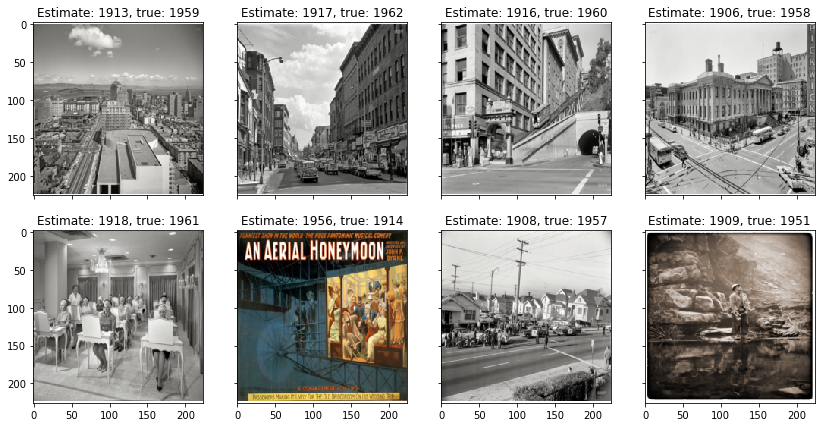

In [50]:
worst = np.where(vgg_errors > 40)[0][:8]
fig, axs = plt.subplots(2, 4, figsize=(14,7), sharex='col', sharey='row')

i = 0
for ax in axs:
    for col in xrange(len(ax)):
        img = X_test[worst[i]] * X_std + X_mean
        img = np.reshape(img, (224, 224, 3)).astype(np.uint8)
        
        ax[col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[col].set_title('Estimate: {:.0f}, true: {}'.format(vgg_preds[worst[i]], 
                                                            y_test[worst[i]]))
        i += 1

As before, the model seems to do a bad job with a couple of city scenes. Some poster seems challenging also.

## Conclusion

Utilizing pre-trained convolutional filters from the VGG16 was found to improve the prediction accuracy a bit on this data set. VGG16 is originally trained on [ImageNet](http://www.image-net.org/), which contains coloured images of objects belonging to 1000 different classes. Therefore the learned weights are not perfect for a regression problem on mostly black and white images. However, the decrease in mean absolute error on the test set was almost one year compared to the CNN trained from scratch. It is possible that the architecture of the CNN trained from scratch was not optimal as it was relatively simple. Still, probably the best way to improve the models would be to collect more training data. 

In a [recent study](https://link.springer.com/chapter/10.1007/978-3-319-56608-5_57), researchers made similar kind of experiments but with more than a million images. They achieved a mean absolute error of 7.5 with the regression approach. The researchers also tried to solve the problem with classification and got slightly better results (7.3 MAE). Interestingly, they also measured human error on a problem like this and found out human MAE was 10.9. Based on this, our fine-tuned VGG model surpasses the human capability - while being trained only on 6447 images!